## Web Scraping Project

### เขียนบทนำเกี่ยวกับโปรเจ็กต์ อธิบายวัตถุประสงค์และความสำคัญของการวิเคราะห์ข้อมูลจากเว็บ

ขั้นตอนที่ 1 การดึงข้อมูลจากเว็บ (Web Scraping) 

ขั้นตอนที่ 2 การทำความสะอาดและเตรียมข้อมูล (Data Cleaning and Preparation)

ขั้นตอนที่ 3 การวิเคราะห์ข้อมูล (Data Analysis)

In [5]:
import pandas as pd
import scipy.stats as stats
# โหลดข้อมูลที่ cleanแล้ว
df = pd.read_csv('cleaned_data.csv')

Genre
Erotica               5.000000
Adult Fiction         5.000000
Novels                5.000000
Christian Fiction     4.166667
Health                3.750000
Art                   3.625000
Poetry                3.526316
Humor                 3.400000
Spirituality          3.333333
Young Adult           3.296296
Womens Fiction        3.250000
New Adult             3.166667
Music                 3.166667
Historical Fiction    3.160000
Fiction               3.156250
Fantasy               3.083333
Suspense              3.000000
Autobiography         3.000000
Historical            3.000000
Religion              3.000000
Sports and Games      3.000000
Mystery               3.000000
History               2.944444
Sequential Art        2.931507
Science               2.928571
Business              2.916667
Food and Drink        2.900000
Nonfiction            2.880734
Default               2.841060
Add a comment         2.761194
Thriller              2.727273
Horror                2.705882
Ch

In [7]:
#จัดอันดับความนิยมของหนังสือแต่ล่ะประเภทและ หาค่าเฉลี่ยของ price ตามประเภท
genre_mean_price_rating = df.groupby('Genre')[['Rating','Price']].mean()
ranking_genre_byRating = genre_mean_price_rating.sort_values(by='Rating', ascending=False)
ranking_genre_byRating

,Rating,Price
Genre,,
Erotica,5.000000,19.190000
Adult Fiction,5.000000,15.360000
Novels,5.000000,54.810000
Christian Fiction,4.166667,34.385000
Health,3.750000,51.452500
Art,3.625000,38.520000
Poetry,3.526316,35.974211
Humor,3.400000,33.501000
Spirituality,3.333333,35.098333


In [16]:
#การทดสอบ ANOVA สำหรับความแตกต่างของราคาตาม Genre
f_val, p_val = stats.f_oneway(*(df[df['Genre'] == genre]['Price'] for genre in df['Genre'].unique()))
print("F-Value of genre:", f_val)
print("P-Value of genre:", p_val)

#------------------------------------------------------------------------------------------------------

#การทดสอบ ANOVA สำหรับความแตกต่างของราคาตาม rating
df['Rating_Category'] = pd.cut(df['Rating'],
                               bins=[0, 2, 4, 5],  # กำหนดช่วงคะแนน
                               labels=['Low', 'Medium', 'High'])  # ตั้งชื่อกลุ่ม
# สร้างลิสต์ของข้อมูลราคาในแต่ละกลุ่มของ Rating
price_by_rating = [df[df['Rating_Category'] == category]['Price'] for category in df['Rating_Category'].unique()]

# ทำการทดสอบ ANOVA
f_val, p_val = stats.f_oneway(*price_by_rating)

print("F-Value of rating:", f_val)
print("P-Value of rating:", p_val)


F-Value of genre: 0.9946210445528134
P-Value of genre: 0.4855264643252697
F-Value of rating: 0.3894629574907809
P-Value of rating: 0.67752570379754


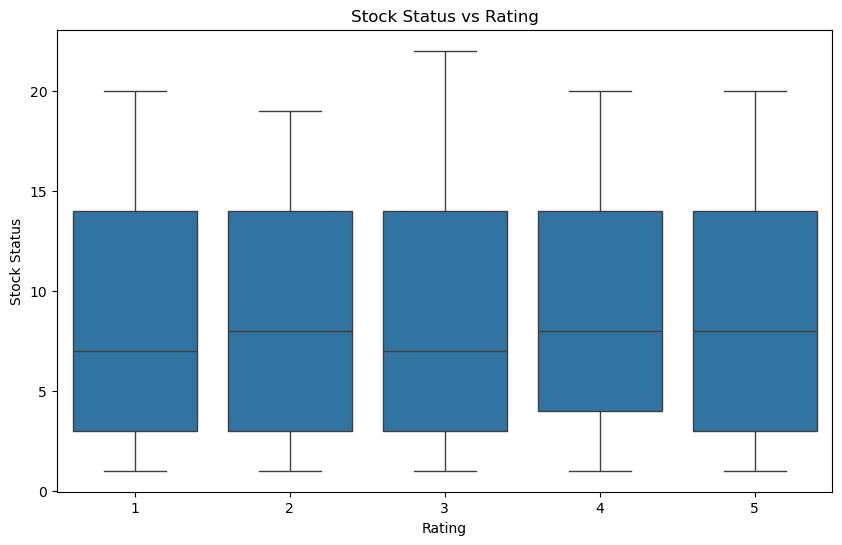

Average Stock Status by Genre:
Genre
Academic               5.000000
Add a comment          7.701493
Adult Fiction          3.000000
Art                    9.000000
Autobiography          6.333333
Biography              8.600000
Business              11.083333
Childrens              8.142857
Christian             12.333333
Christian Fiction      9.166667
Classics               3.117647
Contemporary          11.000000
Crime                 15.000000
Cultural              15.000000
Default                8.900662
Erotica               15.000000
Fantasy                7.750000
Fiction                9.171875
Food and Drink        10.633333
Health                12.250000
Historical            10.000000
Historical Fiction     7.720000
History               10.055556
Horror                 8.000000
Humor                  8.400000
Music                  9.166667
Mystery                9.600000
New Adult              8.166667
Nonfiction             8.935780
Novels                 9.000000
Par

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
# แสดงการกระจายของ Stock Status ตาม Rating
plt.figure(figsize=(10, 6))
sns.boxplot(y='Stock Status', x='Rating', data=df)
plt.title('Stock Status vs Rating')
plt.show()

# การวิเคราะห์ความสัมพันธ์ของ Stock Status กับ Genre
stock_status_genre = df.groupby('Genre')['Stock Status'].mean()

print("Average Stock Status by Genre:")
print(stock_status_genre)
